# Case Study - The effect of anode thickness on the specific capacity

In this case study we will to show the state of charge of a battery using the SPMe model. Initial conditions are specified to start each electrode in 1/2 charged state. A charge and discharge are performed with current chosen to be 1C rate when electrode dimensions are equal.

Coulomb counting is performed to calculate the capacity of the battery within the operating voltage limits and maximum particle concentrations that are specified as parameters. The anode thickenss is varied to highlight the importance of electrode sizing to enable full lithium utilization.

In [22]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
pybamm.set_logging_level(50)

Keeping the thickness of the cathode fixed we will iteratively increase the anode thickness and perform a charge from the initial conditions followed by a discharge from the same initial conditions.
First some lists are created to store the results of the simulations and the thickness for the anode are defined.

In [85]:
factor = 5.0
capacities = []
specific_capacities = []
solutions = []
l_p = 1e-4
thicknesses = np.linspace(1.0, 2.5, 11) * l_p

Now looping through the thicknesses we calculate the volume of the cell and run each charge and discharge simulation and print some information

For simplicity a new simulation is created each time.

In [86]:
for l_n in thicknesses:
    solutions.append([])
    e_ratio = np.around(l_n / l_p, 3)
    # Dimensions
    h = 0.137
    w = 0.207 / factor
    A = h * w
    l_s = 2.5e-5
    l1d = l_n + l_p + l_s
    vol = h * w * l1d
    vol_cm3 = vol * 1e6
    tot_cap = 0.0
    tot_time = 0.0
    
    I_mag = 1.00 / factor
    print("*" * 60)
    print('Anode Thickness ' + str(np.around(l_n*1e6, 3)) + 'um')
    for enum, I_app in enumerate([-1.0, 1.0]):
        I_app *= I_mag
        # load model
        model = pybamm.lithium_ion.SPMe()
        # create geometry
        geometry = model.default_geometry
        # load parameter values and process model and geometry
        param = model.default_parameter_values
        param.update(
            {
                "Electrode height [m]": h,
                "Electrode width [m]": w,
                "Negative electrode thickness [m]": l_n,
                "Positive electrode thickness [m]": l_p,
                "Separator thickness [m]": l_s,
                "Lower voltage cut-off [V]": 2.8,
                "Upper voltage cut-off [V]": 4.7,
                "Maximum concentration in negative electrode [mol.m-3]": 25000,
                "Maximum concentration in positive electrode [mol.m-3]": 50000,
                "Initial concentration in negative electrode [mol.m-3]": 12500,
                "Initial concentration in positive electrode [mol.m-3]": 25000,
                "Negative electrode surface area to volume ratio [m-1]": 180000.0,
                "Positive electrode surface area to volume ratio [m-1]": 150000.0,
                "Current function [A]": I_app,
            }
        )
        param.process_model(model)
        param.process_geometry(geometry)
        s_var = pybamm.standard_spatial_vars
        var_pts = {
            s_var.x_n: 5,
            s_var.x_s: 5,
            s_var.x_p: 5,
            s_var.r_n: 5,
            s_var.r_p: 10,
        }
        # set mesh
        mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)
        # discretise model
        disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
        disc.process_model(model)
        # solve model
        t_eval = np.linspace(0, 3600, 100)
        sol = pybamm.CasadiSolver(mode='safe').solve(model, t_eval)
        solutions[-1].append(sol)
        time = sol["Time [h]"]
        # Coulomb counting
        time_secs = sol["Time [s]"].entries
        time_hours = time(time_secs)
        dc_time = np.around(time_hours[-1], 3)
        # Capacity mAh
        cap = np.absolute(I_app * 1000 * dc_time)
        cap_time = np.absolute(I_app * 1000 * time_hours)
        print(
            "Applied Current",
            np.around(I_app, 3),
            "A",
            "Time",
            np.around(dc_time, 3),
            "hrs",
            "Capacity",
            np.around(cap, 3),
            "mAh",
        )
        print('Termination event: '+sol.termination)
        tot_cap += cap
        tot_time += dc_time

    print("Anode : Cathode thickness", e_ratio)
    print("Total Charge/Discharge Time", tot_time, "hrs")
    print("Total Capacity", np.around(tot_cap, 3), "mAh")
    specific_cap = np.around(tot_cap, 3) / vol_cm3
    print("Total Capacity", specific_cap, "mAh.cm-3")
    capacities.append(tot_cap)
    specific_capacities.append(specific_cap)

************************************************************
Anode Thickness 100.0um


c:\users\tom\code\pybamm\pybamm\solvers\casadi_solver.py:201: RuntimeWarning: invalid value encountered in sign
  for event in model.terminate_events_eval


Applied Current -0.2 A Time 0.515 hrs Capacity 103.0 mAh
Termination event: event: Maximum negative particle surface concentration
Applied Current 0.2 A Time 0.505 hrs Capacity 101.0 mAh
Termination event: event: Minimum voltage
Anode : Cathode thickness 1.0
Total Charge/Discharge Time 1.02 hrs
Total Capacity 204.0 mAh
Total Capacity 159.85519000434897 mAh.cm-3
************************************************************
Anode Thickness 115.0um
Applied Current -0.2 A Time 0.586 hrs Capacity 117.2 mAh
Termination event: event: Maximum voltage
Applied Current 0.2 A Time 0.586 hrs Capacity 117.2 mAh
Termination event: event: Minimum voltage
Anode : Cathode thickness 1.15
Total Charge/Discharge Time 1.172 hrs
Total Capacity 234.4 mAh
Total Capacity 172.19695099733184 mAh.cm-3
************************************************************
Anode Thickness 130.0um
Applied Current -0.2 A Time 0.626 hrs Capacity 125.2 mAh
Termination event: event: Maximum voltage
Applied Current 0.2 A Time 0.677 

We can access the solution data for each simulation after it has finished by indexing into the list 

In [87]:
solutions[0][0].termination

'event: Maximum negative particle surface concentration'

The total battery capacity was calculated by coulomb counting for charge and dicharge. We want to plot the results together so to get the maximum capacity the list is turned into an array

In [88]:
max_cap = np.asarray(capacities).max()

A plot function is now defined which we can interact with by changing the index of the simulations corresponding to a specific anode thickness

In [89]:
def plot_inter(x):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7.5), sharey=True)
    desc = 'Anode Thickness ' + str(np.around(thicknesses[x]*1e6, 3)) + 'um'
    for enum, sol in enumerate(solutions[x]):
        xpext = sol["Positive electrode average extent of lithiation"]
        xnext = sol["Negative electrode average extent of lithiation"]
        xpsurf = sol["X-averaged positive particle surface concentration"]
        xnsurf = sol["X-averaged negative particle surface concentration"]
        time = sol["Time [h]"]
        # Coulomb counting
        time_secs = sol["Time [s]"].entries
        time_hours = time(time_secs)
        dc_time = np.around(time_hours[-1], 3)
        # Capacity mAh
        cap = np.absolute(I_app * 1000 * dc_time)
        cap_time = np.absolute(I_app * 1000 * time_hours)
        axes[enum].plot(cap_time, xnsurf(time_secs), "r--", label="Surface Neg")
        axes[enum].plot(cap_time, xnext(time_secs), "r-", label="Average Neg")
        axes[enum].plot(cap_time, xpsurf(time_secs), "b--", label="Surface Pos")
        axes[enum].plot(cap_time, xpext(time_secs), "b-", label="Average Pos")
        axes[enum].set_xlabel("Capacity [mAh]")
        handles, labels = axes[enum].get_legend_handles_labels()
        axes[enum].legend(handles, labels, loc='upper left')
        if enum == 0:
            axes[enum].set_ylabel(
                "Extent of Lithiation, Elecrode Ratio: " + str(e_ratio)
            )
            axes[enum].title.set_text("Charge "+desc)
        else:
            axes[enum].title.set_text("Discharge "+desc)
        axes[enum].set_ylim([0, 1.0])
        axes[enum].set_xlim([0, np.ceil(max_cap/2)])

In [90]:
interact(plot_inter, x=widgets.IntSlider(min=0, max=len(thicknesses)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_inter(x)>

Observe that the surface and average particle concentrations or state of lithiations are different and that the positive particle lithiation never reaches it's minimum or maximum values. For the first simulation the charge results in the maximum anode particle surface concentration being reached but there is still plenty of Lithium in the cathode. Increasing the thickness of the anode means that the anode capacity increases to match the cathode and the rate at which the particles in anode lithiate becomes relatively slower. 

Plotting the specific volumetric capacity of the battery vs anode thickness reveals there is an optimum value within the operating voltage limits

Text(0.5, 0, 'Anode : Cathode thickness ratio')

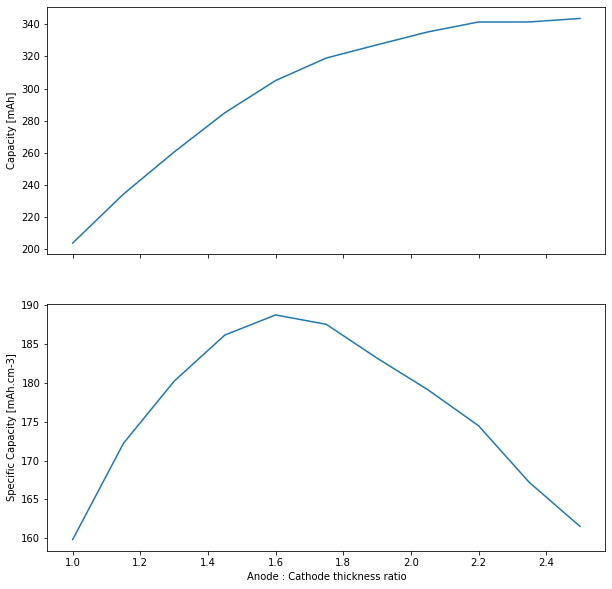

In [80]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.plot(thicknesses / l_p, capacities)
ax2.plot(thicknesses / l_p, specific_capacities)
ax1.set_ylabel("Capacity [mAh]")
ax2.set_ylabel("Specific Capacity [mAh.cm-3]")
ax2.set_xlabel("Anode : Cathode thickness ratio")